# Lab14 - st121413

Independent exercise
Recall that Mnih et al. (2015) obtained superhuman playing ability for some of the Atari games by combining DQN with experience replay and a more sophisticated state representation that what we've seen so far: they stack successive frames as the input state representation so as to give the agent some "velocity" input rather than a static snapshot of the scene.

Try combining the techniques we've developed in the lab with the frame history as state, and get the best Space Invaders player you can. What's your agent's average and best score over 100 games?

I continue from Prioritized experience replay. From there, I notice that to get the stack of observation, I only need to modify the <code>get_state2</code> a bit.

First, I transform the observation to 1-channel grayscale. Then, I stack them up in a shape of (queue,width,height). The queue is max to length of 3 and init with all the first frame. Later on, I pop one out and put new observation in.

This way, I can just put all 3 observations as an input without modifying the DDQN

In [ ]:
image_size = 84
transform = T.Compose([T.ToPILImage(),
                       T.Grayscale(num_output_channels=1),
                       T.Resize((image_size, image_size), interpolation=Image.CUBIC),
                       T.ToTensor()])

In [ ]:
import queue
state_buffer = queue.Queue()
def get_state3(observation):
    
    # First time, repeat the state for 3 times
    if(state_buffer.qsize() == 0):
        for i in range(3):
            state = get_state2(observation)
            state_buffer.put(state)
        # print(observation.shape, state.shape)
    else:
        state_buffer.get()
        state = get_state2(observation)
        state_buffer.put(state)
    # for i in state_buffer.queue:
    #     print(i.shape)
    rep = torch.cat(list(state_buffer.queue), dim=0)
    # print("rep=====",rep.shape)
    return rep

def get_state2(observation):
    state = observation.transpose((2,0,1))
    state = torch.from_numpy(state)
    state = transform(state)
    return state

## result
First, I trained the modal for 200,000 epochs and found that the performance is not any better than what we have done so far.
- Mainly, the agent only shooting at the start spot. It got 215 at best.

I suspected the number of epoches is to little so I train for 1,000,000 epochs and found a little improvement.
- The agent move the ship to the right and shooting from there. Now, it got 285.

Then, I trained more to 50,000,000 epoches.
- The agent act the same as the 1M one. But, it able to shoot the purple UFO and got 800 scores at the end.
- Unfortunately, without the UFO, the agent got 285 score. The only different from the 1M agent is it wiggles (move slightly left and right) when the laser is about to hit the spaceship.

round 0: 235.0 round 1: 290.0 round 2: 320.0 round 3: 270.0 round 4: 280.0 round 5: 235.0 round 6: 270.0 round 7: 290.0 round 8: 280.0 round 9: 270.0

round 10: 280.0 round 11: 800.0 round 12: 280.0 round 13: 270.0 round 14: 265.0 round 15: 270.0 round 16: 320.0 round 17: 800.0 round 18: 290.0 round 19: 235.0

round 20: 270.0 round 21: 290.0 round 22: 270.0 round 23: 200.0 round 24: 270.0 round 25: 275.0 round 26: 800.0 round 27: 270.0 round 28: 270.0 round 29: 280.0

round 30: 235.0 round 31: 280.0 round 32: 285.0 round 33: 285.0 round 34: 270.0 round 35: 280.0 round 36: 270.0 round 37: 270.0 round 38: 235.0 round 39: 235.0

round 40: 270.0 round 41: 270.0 round 42: 800.0 round 43: 270.0 round 44: 270.0 round 45: 270.0 round 46: 280.0 round 47: 800.0 round 48: 270.0 round 49: 290.0

round 50: 170.0 round 51: 270.0 round 52: 210.0 round 53: 235.0 round 54: 800.0 round 55: 270.0 round 56: 270.0 round 57: 290.0 round 58: 270.0 round 59: 280.0

round 60: 800.0 round 61: 800.0 round 62: 185.0 round 63: 800.0 round 64: 235.0 round 65: 275.0 round 66: 235.0 round 67: 270.0 round 68: 270.0 round 69: 270.0

round 70: 185.0 round 71: 380.0 round 72: 295.0 round 73: 270.0 round 74: 280.0 round 75: 290.0 round 76: 265.0 round 77: 270.0 round 78: 225.0 round 79: 270.0

round 80: 800.0 round 81: 270.0 round 82: 270.0 round 83: 235.0 round 84: 290.0 round 85: 270.0 round 86: 270.0 round 87: 270.0 round 88: 195.0 round 89: 270.0

round 90: 265.0 round 91: 270.0 round 92: 270.0 round 93: 240.0 round 94: 275.0 round 95: 270.0 round 96: 270.0 round 97: 235.0 round 98: 215.0 round 99: 290.0


Mean Reward over 100 rounds: 318.55

## Update

After Monday class, I train a new model with frameskip and only train for 1M (since I found that the performace from 1M, 5M, and 50M is little).

The differeces

1. Representation is a stack of 4 observations (which match the DQN paper)
2. The skip feature is only 6 lines. The skip is every k=3 (which match the DQN paper).

<code>
reward = 0

for i in range(3):

    next_obs, i_reward, done, _ = env.step(action)

    reward += i_reward

    if(done): break        
</code>

In [ ]:
def get_state3(observation):
    # First time, repeat the state for 3 times
    if(state_buffer.qsize() == 0):
        for i in range(4):
            state = get_state2(observation)
            state_buffer.put(state)
        # print(observation.shape, state.shape)
    else:
        state_buffer.get()
        state = get_state2(observation)
        state_buffer.put(state)
    # for i in state_buffer.queue:
    #     print(i.shape)
    rep = torch.cat(list(state_buffer.queue), dim=0)
    # print("rep=====",rep.shape)
    return rep

In [ ]:
def train_DDQN_prior_exp_replay(env, current_model, target_model, eps_by_episode, optimizer, replay_buffer, beta_by_episode, episodes = 10000, batch_size=32, gamma = 0.99, min_play_reward=-.15):
    losses = []
    all_rewards = []
    episode_reward = 0

    obs = env.reset()
    state = get_state3(obs)
    tot_reward = 0
    tr = trange(episodes+1, desc='Agent training', leave=True)
    for episode in tr:
        avg_reward = tot_reward / (episode + 1)
        tr.set_description("Agent training (episode{}) Avg Reward {}".format(episode+1,avg_reward))
        tr.refresh() 

        # get action with q-values
        epsilon = eps_by_episode(episode)
        action = current_model.act(state, epsilon, env, device)
        
        # input action into state
        reward = 0
        for i in range(3):
            next_obs, i_reward, done, _ = env.step(action)
            reward += i_reward
            if(done): break
        next_state = get_state3(next_obs)
        # save data into buffer
        replay_buffer.push(state, action, reward, next_state, done)

        tot_reward += reward
        
        state = next_state
        obs = next_obs
        episode_reward += reward
        
        if done:
            obs = env.reset()
            state = get_state3(obs)
            all_rewards.append(episode_reward)
            episode_reward = 0
            
        if len(replay_buffer) > batch_size:
            beta = beta_by_episode(episode)
            loss = compute_td_loss_DDQN_prior_exp_replay(current_model, target_model, batch_size, gamma, beta)
            losses.append(loss.item())

        if episode % 500 == 0:
            update_target(current_model, target_model)

round 0: 270.0 round 1: 270.0 round 2: 270.0 round 3: 270.0 round 4: 185.0 round 5: 235.0 round 6: 270.0 round 7: 235.0 round 8: 270.0 round 9: 270.0

round 10: 270.0 round 11: 270.0 round 12: 235.0 round 13: 285.0 round 14: 265.0 round 15: 270.0 round 16: 270.0 round 17: 270.0 round 18: 225.0 round 19: 270.0

round 20: 270.0 round 21: 255.0 round 22: 215.0 round 23: 185.0 round 24: 270.0 round 25: 270.0 round 26: 270.0 round 27: 235.0 round 28: 270.0 round 29: 270.0

round 30: 270.0 round 31: 270.0 round 32: 300.0 round 33: 185.0 round 34: 270.0 round 35: 270.0 round 36: 270.0 round 37: 240.0 round 38: 235.0 round 39: 290.0

round 40: 270.0 round 41: 285.0 round 42: 160.0 round 43: 305.0 round 44: 270.0 round 45: 270.0 round 46: 280.0 round 47: 235.0 round 48: 270.0 round 49: 425.0

round 50: 290.0 round 51: 270.0 round 52: 270.0 round 53: 285.0 round 54: 290.0 round 55: 270.0 round 56: 270.0 round 57: 270.0 round 58: 270.0 round 59: 280.0

round 60: 555.0 round 61: 280.0 round 62: 280.0 round 63: 270.0 round 64: 185.0 round 65: 270.0 round 66: 280.0 round 67: 235.0 round 68: 270.0 round 69: 185.0

round 70: 235.0 round 71: 270.0 round 72: 270.0 round 73: 270.0 round 74: 270.0 round 75: 270.0 round 76: 270.0 round 77: 270.0 round 78: 245.0 round 79: 235.0

round 80: 270.0 round 81: 270.0 round 82: 195.0 round 83: 450.0 round 84: 280.0 round 85: 270.0 round 86: 230.0 round 87: 270.0 round 88: 270.0 round 89: 270.0

round 90: 290.0 round 91: 270.0 round 92: 195.0 round 93: 270.0 round 94: 270.0 round 95: 270.0 round 96: 270.0 round 97: 270.0 round 98: 270.0 round 99: 270.0

Mean Reward over 100 rounds: 266.55

The avg.reward during training is much better in skipping frame version (about 0.3 for unskip vs about 0.9 for skip).

The mean_noskip for 100 round is 318.55 which is better than the skipped version (266.55)

Therefore, I plot the histrogram to see if the skipped agent has more consistent performace or not.


In [1]:
import matplotlib.pyplot as plt
unskip = [235.0,290.0,320.0,270.0,280.0,235.0,270.0,290.0,280.0,270.0,280.0,800.0,280.0,270.0,265.0,270.0,320.0,800.0,290.0,235.0,270.0,290.0,270.0,200.0,270.0,275.0,800.0,270.0,270.0,280.0,235.0,280.0,285.0,285.0,270.0,280.0,270.0,270.0,235.0,235.0,270.0,270.0,800.0,270.0,270.0,270.0,280.0,800.0,270.0,290.0,170.0,270.0,210.0,235.0,800.0,270.0,270.0,290.0,270.0,280.0,800.0,800.0,185.0,800.0,235.0,275.0,235.0,270.0,270.0,270.0,185.0,380.0,295.0,270.0,280.0,290.0,265.0,270.0,225.0,270.0,800.0,270.0,270.0,235.0,290.0,270.0,270.0,270.0,195.0,270.0,265.0,270.0,270.0,240.0,275.0,270.0,270.0,235.0,215.0,290.0]

skip = [270.0,270.0,270.0,270.0,185.0,235.0,270.0,235.0,270.0,270.0,270.0,270.0,235.0,285.0,265.0,270.0,270.0,270.0,225.0,270.0,270.0,255.0,215.0,185.0,270.0,270.0,270.0,235.0,270.0,270.0,270.0,270.0,300.0,185.0,270.0,270.0,270.0,240.0,235.0,290.0,270.0,285.0,160.0,305.0,270.0,270.0,280.0,235.0,270.0,425.0,290.0,270.0,270.0,285.0,290.0,270.0,270.0,270.0,270.0,280.0,555.0,280.0,280.0,270.0,185.0,270.0,280.0,235.0,270.0,185.0,235.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0,245.0,235.0,270.0,270.0,195.0,450.0,280.0,270.0,230.0,270.0,270.0,270.0,290.0,270.0,195.0,270.0,270.0,270.0,270.0,270.0,270.0,270.0]

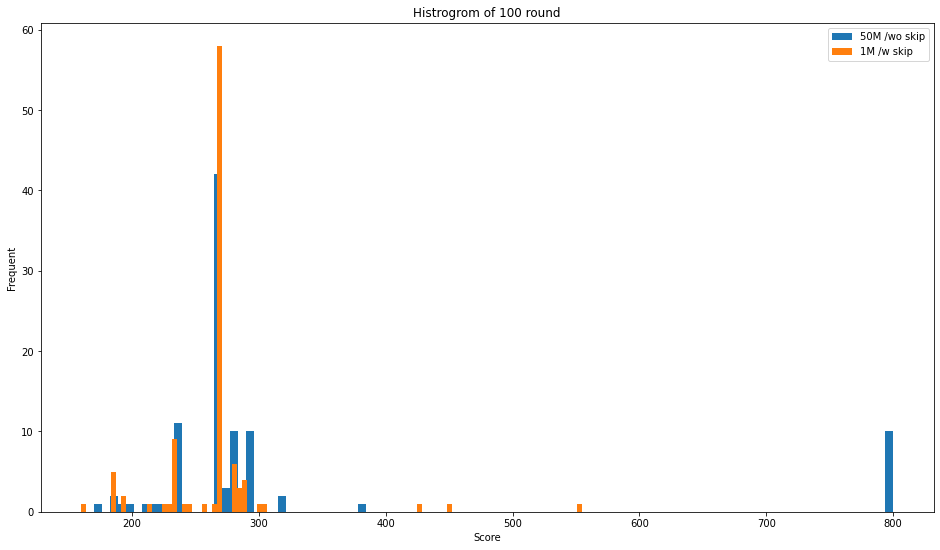

In [15]:
fig, ax = plt.subplots(figsize=(16,9))
ax.hist(unskip,bins=100, label='50M /wo skip')
ax.hist(skip, bins=100, label= '1M /w skip')
ax.set_xlabel("Score")
ax.set_ylabel("Frequent")
ax.set_title("Histrogrom of 100 round")
ax.legend()
plt.show()

The two agents play pretty much the same strategy. Once the game start, they move the space ship to the far right and keep shooting over there.

The different between the two agent are

1. The noskip agent can get 2 purple ufo consistent (which give a large reward) (The 10 times the game play with purple ufo, the agent managed to get 2 everytime)
2. The skipped agent get more generic enemy on the way to the right. 

